# Train Word2Vec and FastText Models
- using 'ingredients_simple' column, pre-process text into corpus

In [1]:
import os
import sys
import logging

import numpy as np
import pandas as pd 

from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric,\
        strip_non_alphanum, strip_multiple_whitespaces, strip_short
from textblob import TextBlob, Word
import collections
import re
from time import time  # To log the operations time

import multiprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
df_recipes = pd.read_csv('data/recipes_feature_engineered.csv')
df_recipes.head(3)

,id,partition,title,url,nutr_values_per100g_energy,nutr_values_per100g_fat,nutr_values_per100g_protein,nutr_values_per100g_salt,nutr_values_per100g_saturates,nutr_values_per100g_sugars,url_domain,ingredients_count,instructions_steps,ingredients_simple,instructions_simple
0,000095fc1d,train,Yogurt Parfaits,http://tastykitchen.com/recipes/breakfastbrunc...,81.129461,2.140139,6.914437,0.055978,0.365347,5.086341,tastykitchen.com,3,1,"['yogurt', 'strawberries', 'cereals ready-to-e...",['Layer all ingredients in a serving dish.']
1,00051d5b9d,val,"Salt Free, Low Cholesterol Sugar Cookies Recipe",http://cookeatshare.com/recipes/salt-free-low-...,477.096404,23.412486,7.625492,0.548621,3.425054,14.298443,cookeatshare.com,7,9,"['sugars', 'oil', 'egg substitute', 'orange ju...",['Cream sugar and butter together till smooth....
2,00059b093b,train,Honey Sriracha Chicken Wings,http://tastykitchen.com/recipes/main-courses/h...,208.058983,14.297046,15.383456,1.063915,4.535687,3.048951,tastykitchen.com,12,11,"['chicken', 'salt', 'pepper', 'oil', 'butter',...","['Preheat oven to 400 degrees F.', 'In a large..."


In [7]:
# to add screenshot to reporting
# simple = df_recipes[["title","ingredients_count","instructions_steps","ingredients_simple","instructions_simple","nutr_values_per100g_energy","nutr_values_per100g_fat","nutr_values_per100g_protein","nutr_values_per100g_salt"]]
# simple.head(8)

In [9]:
# get the training set

df_recipes_train = df_recipes[df_recipes['partition'] != 'test'].copy()
print("Train data:", len(df_recipes_train))

df_recipes_test = df_recipes[df_recipes['partition'] == 'test'].copy()
print("Test data:", len(df_recipes_test))

Train data: 43554
Test data: 7681


In [11]:
df_recipes['ingredients_simple'] = df_recipes['ingredients_simple'].apply(lambda x: x.lower())

ingredient_column = df_recipes_train['ingredients_simple']

all_receipes_ingredients =  []
total_ingredients = []

count = 0
for i in ingredient_column:
    all_ingredients = list()
    
    for ing in (i.split(',')):
        ing = ing.lower()
        ing = remove_stopwords(ing)
        ing = strip_numeric(ing)
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing)
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        
        #convert plurals to singular e.g. tomatoes --> tomato
        ing = (" ".join(TextBlob(ing).words.singularize()))
        
        if(len(ing.strip()) > 0):
            all_ingredients.append(ing)
            total_ingredients.append(ing)
        
    all_receipes_ingredients.append(all_ingredients)

counts_ingr = collections.Counter(total_ingredients)

print('Total Ingredients (with repetition):  \t{}'.format((len(total_ingredients))))
print('Unique Ingredients : \t\t\t{}'.format((len(counts_ingr.values()))))
print('Total Receipes:  \t\t\t{}'.format((len(all_receipes_ingredients))))

Total Ingredients (with repetition):  	261064
Unique Ingredients : 			240
Total Receipes:  			43554


### Training the model

In [12]:
# Step1: set up the parameters

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
num_features = 300          # Word vector dimensionality                      
min_word_count = 5                        
context_window_size = 4    # Context window size; 
downsampling = 1e-2         # threshold for configuring which 
                            # higher-frequency words are randomly downsampled
sg = 0 # CBOW: build a language model that correctly predicts the center word given the context words in which the center word appears

w2v_model = Word2Vec(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=num_features,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     compute_loss=True,
                     sg=sg)

INFO - 10:26:42: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2023-01-18T10:26:42.676291', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'created'}


In [13]:
# Step2: building the vocabulary

t = time()

w2v_model.build_vocab(all_receipes_ingredients, progress_per=5000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:26:46: collecting all words and their counts
INFO - 10:26:46: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:26:46: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:26:46: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:26:46: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:26:46: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:26:46: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:26:46: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:26:46: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:26:46: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:26:46: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:26:46: C

Time to build vocab: 0.0 mins


In [14]:
# Step 3: Train the model

t = time()

w2v_model.train(all_receipes_ingredients, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:26:50: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 300 features, using sg=0 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:26:50.706140', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:26:50: EPOCH 0: training on 261064 raw words (221094 effective words) took 0.3s, 881220 effective words/s
INFO - 10:26:51: EPOCH 1: training on 261064 raw words (221161 effective words) took 0.2s, 912364 effective words/s
INFO - 10:26:51: EPOCH 2: training on 261064 raw words (220682 effective words) took 0.3s, 800264 effective words/s
INFO - 10:26:51: EPOCH 3: training on 261064 raw words (220892 effective words) took 0.3s, 876839 effective words/s
INFO - 10:26:52: EPOCH 4: training on 261064 raw words (221342 effective words) took 0.2s, 893655 effective words/s
INFO - 10:26:52: E

Time to train the model: 0.13 mins


In [15]:
print("Vocab", len(w2v_model.wv.index_to_key))
print("Training loss", w2v_model.get_latest_training_loss())

Vocab 237
Training loss 0.0


In [16]:
w2v_model.wv.most_similar('chicken')

[('turkey', 0.6301716566085815),
 ('crustacean', 0.6083016991615295),
 ('fish', 0.4957888126373291),
 ('oyster sauce', 0.4835631549358368),
 ('pork', 0.4502709209918976),
 ('onion', 0.4407683312892914),
 ('asparagu', 0.439227819442749),
 ('beef', 0.4287015199661255),
 ('curry powder', 0.41915813088417053),
 ('mollusk', 0.4079648554325104)]

In [17]:
w2v_model.wv.most_similar('broccoli')

[('pea', 0.6245932579040527),
 ('asparagu', 0.5431194305419922),
 ('mushroom', 0.5317960381507874),
 ('denny s', 0.47350409626960754),
 ('cabbage', 0.46564486622810364),
 ('celery', 0.455764502286911),
 ('spinach', 0.45392462611198425),
 ('amame', 0.4517017900943756),
 ('lentil', 0.4463176429271698),
 ('leek', 0.44040805101394653)]

In [18]:
print(w2v_model)

#Summarize vocabulary
words = list(w2v_model.wv.index_to_key)
words.sort()
print(words)

Word2Vec<vocab=237, vector_size=300, alpha=0.03>
['a cajun life', 'alcoholic beverage', 'amame', 'amazona rainforest product', 'animal fat', 'apple', 'apple juice', 'applesauce', 'apricot', 'artichoke', 'arugula', 'asparagu', 'avocado', 'bacon', 'baking chocolate', 'banana', 'barbecue sauce', 'barley', 'basil', 'bay leaf', 'bean', 'beef', 'beet', 'beverage', 'blackberry', 'blueberry', 'bread crumb', 'broccoli', 'brussel sprout', 'bulgur', 'butter', 'cabbage', 'candy', 'caper', 'cardamom', 'carob flmy', 'carrot', 'catsup', 'cauliflower', 'celery', 'cereal', 'cereal ready to eat', 'cheese', 'cherry', 'chicken', 'chickpea flmy besan', 'chickpea garbanzo bean', 'chili powder', 'chive', 'chocolate', 'cinnamon', 'clove', 'cock brand', 'cocoa', 'cookie', 'corn', 'cornmeal', 'cornstarch', 'couscou', 'cranberry', 'cranberry juice', 'cranberry sauce', 'cream', 'creole seasoning', 'crouton', 'crustacean', 'currant', 'curry powder', 'date', 'delallo', 'denny s', 'dulce leche', 'egg', 'egg substitu

In [19]:
# Save the model
w2v_model.save('models/w2v_model_single.bin')

INFO - 10:27:25: Word2Vec lifecycle event {'fname_or_handle': 'models/w2v_model_single.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-01-18T10:27:25.708293', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'saving'}
INFO - 10:27:25: not storing attribute cum_table
INFO - 10:27:25: saved models/w2v_model_single.bin


# t-SNE Visualizations of Word2Vec

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [21]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('Word2Vec Model: t-SNE visualization for {}'.format(word.title()))

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


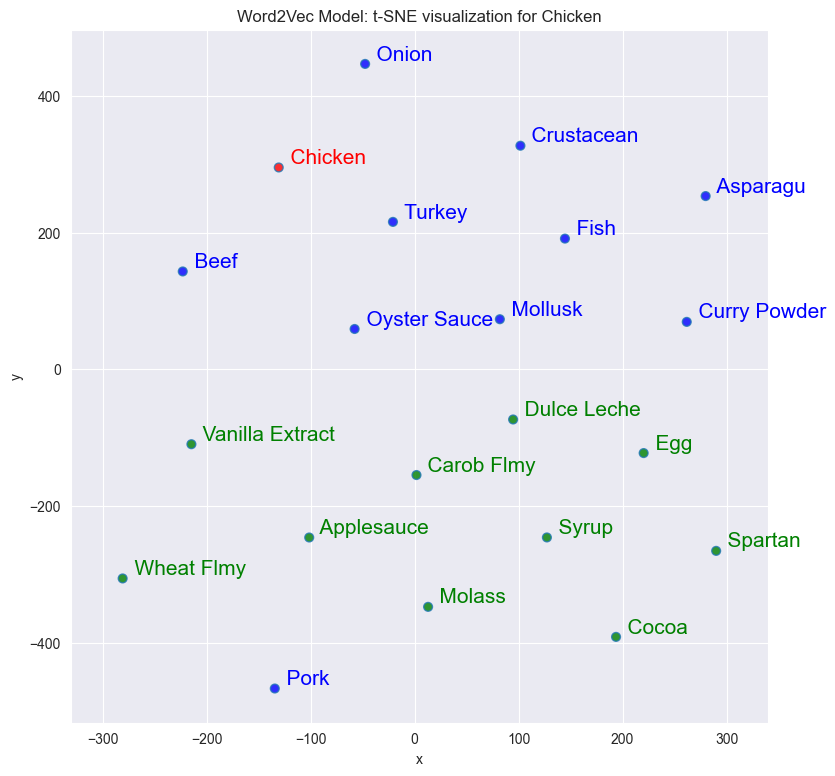

In [22]:
tsnescatterplot(w2v_model, 'chicken', [i[0] for i in w2v_model.wv.most_similar(negative=["chicken"])])

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


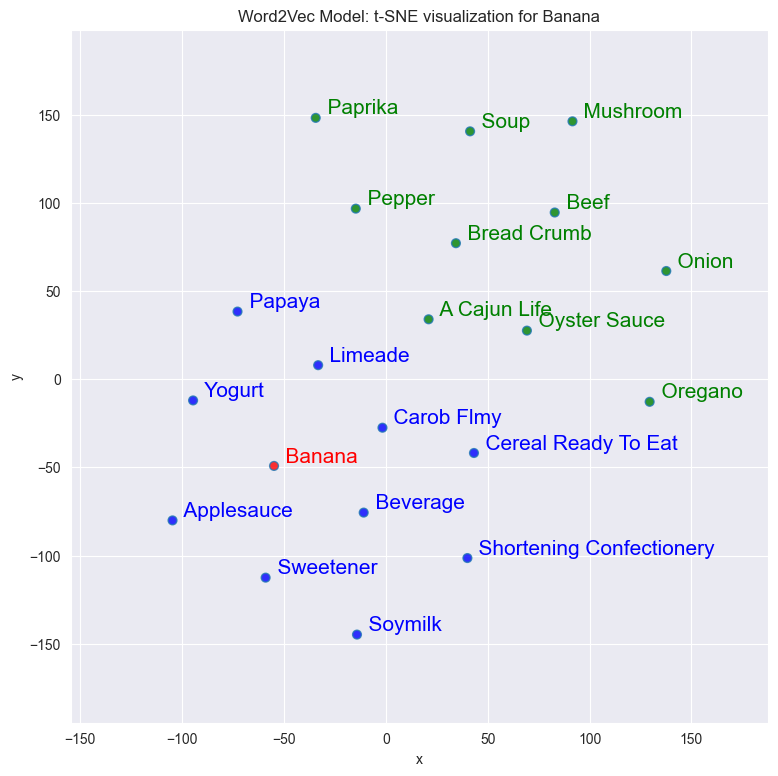

In [24]:
tsnescatterplot(w2v_model, 'banana', [i[0] for i in w2v_model.wv.most_similar(negative=["banana"])])

# Word2Vec Model

cores: Count the number of cores in a computer
num_features: Word vector dimensionality                      
min_word_count: 5                        
context_window_size: Context window size
downsampling: threshold for configuring which higher-frequency words are randomly downsampled
sg = 0 # CBOW: build a language model that correctly predicts the center word given the context words in which the center word appears
sg = 1 #skip-gram


### Train 4 variations
- Word2Vec CBOW 200 dimensions
- Word2Vec CBOW 300 dimensions
- Word2Vec Skip-gram 200 dimensions
- Word2Vec Skip-gram 300 dimensions

In [25]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer 
min_word_count = 5                        
context_window_size = 4    # Context window size; 
downsampling = 1e-2         # threshold for configuring which higher-frequency words are randomly downsampled

w2v_model_cbow_200 = Word2Vec(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=200,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     compute_loss=True,
                     sg=0)
w2v_model_cbow_300 = Word2Vec(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=300,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     compute_loss=True,
                     sg=0)
w2v_model_skipgram_200 = Word2Vec(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=200,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     compute_loss=True,
                     sg=1)
w2v_model_skipgram_300 = Word2Vec(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=300,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     compute_loss=True,
                     sg=1)

INFO - 10:28:18: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=200, alpha=0.03>', 'datetime': '2023-01-18T10:28:18.255184', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 10:28:18: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2023-01-18T10:28:18.258726', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 10:28:18: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=200, alpha=0.03>', 'datetime': '2023-01-18T10:28:18.260607', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 10:28:18: Word2Vec lifecycle event {

In [26]:
t = time()
w2v_model_cbow_200.build_vocab(all_receipes_ingredients, progress_per=5000)
print('w2v_model_cbow_200: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:28:22: collecting all words and their counts
INFO - 10:28:22: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:28:22: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:28:22: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:28:22: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:28:22: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:28:22: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:28:22: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:28:22: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:28:22: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:28:22: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:28:22: C

w2v_model_cbow_200: Time to build vocab: 0.0 mins


In [27]:
t = time()
w2v_model_cbow_300.build_vocab(all_receipes_ingredients, progress_per=5000)
print('w2v_model_cbow_300: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:28:27: collecting all words and their counts
INFO - 10:28:27: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:28:27: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:28:27: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:28:27: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:28:27: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:28:27: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:28:27: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:28:27: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:28:27: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:28:27: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:28:27: C

w2v_model_cbow_300: Time to build vocab: 0.0 mins


In [28]:
t = time()
w2v_model_skipgram_200.build_vocab(all_receipes_ingredients, progress_per=5000)
print('w2v_model_skipgram_200: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:28:31: collecting all words and their counts
INFO - 10:28:31: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:28:31: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:28:31: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:28:31: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:28:31: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:28:31: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:28:31: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:28:31: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:28:31: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:28:31: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:28:31: C

w2v_model_skipgram_200: Time to build vocab: 0.0 mins


In [29]:
t = time()
w2v_model_skipgram_300.build_vocab(all_receipes_ingredients, progress_per=5000)
print('w2v_model_skipgram_300: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:28:35: collecting all words and their counts
INFO - 10:28:35: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:28:35: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:28:35: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:28:35: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:28:35: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:28:35: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:28:36: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:28:36: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:28:36: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:28:36: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:28:36: C

w2v_model_skipgram_300: Time to build vocab: 0.0 mins


In [30]:
# Train the model w2v_model_cbow_200
t = time()
w2v_model_cbow_200.train(all_receipes_ingredients, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('w2v_model_cbow_200: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:28:39: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 200 features, using sg=0 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:28:39.382641', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:28:39: EPOCH 0: training on 261064 raw words (221009 effective words) took 0.2s, 1074123 effective words/s
INFO - 10:28:39: EPOCH 1: training on 261064 raw words (221030 effective words) took 0.2s, 1115993 effective words/s
INFO - 10:28:40: EPOCH 2: training on 261064 raw words (220849 effective words) took 0.2s, 1196501 effective words/s
INFO - 10:28:40: EPOCH 3: training on 261064 raw words (220729 effective words) took 0.2s, 1200868 effective words/s
INFO - 10:28:40: EPOCH 4: training on 261064 raw words (220880 effective words) took 0.2s, 1158874 effective words/s
INFO - 10:28:

w2v_model_cbow_200: Time to train the model: 0.1 mins


In [31]:
# Train the model w2v_model_cbow_300
t = time()
w2v_model_cbow_300.train(all_receipes_ingredients, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('w2v_model_cbow_300: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:28:48: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 300 features, using sg=0 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:28:48.006380', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:28:48: EPOCH 0: training on 261064 raw words (221138 effective words) took 0.2s, 997030 effective words/s
INFO - 10:28:48: EPOCH 1: training on 261064 raw words (220884 effective words) took 0.2s, 900578 effective words/s
INFO - 10:28:48: EPOCH 2: training on 261064 raw words (220659 effective words) took 0.2s, 922886 effective words/s
INFO - 10:28:49: EPOCH 3: training on 261064 raw words (220922 effective words) took 0.3s, 876153 effective words/s
INFO - 10:28:49: EPOCH 4: training on 261064 raw words (220811 effective words) took 0.2s, 932250 effective words/s
INFO - 10:28:49: E

w2v_model_cbow_300: Time to train the model: 0.13 mins


In [32]:
# Train the model w2v_model_skipgram_200
t = time()
w2v_model_skipgram_200.train(all_receipes_ingredients, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('w2v_model_skipgram_200: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:28:57: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 200 features, using sg=1 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:28:57.986959', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:28:58: EPOCH 0: training on 261064 raw words (220968 effective words) took 0.5s, 409050 effective words/s
INFO - 10:28:59: EPOCH 1: training on 261064 raw words (221069 effective words) took 0.5s, 423248 effective words/s
INFO - 10:28:59: EPOCH 2: training on 261064 raw words (220644 effective words) took 0.5s, 428979 effective words/s
INFO - 10:29:00: EPOCH 3: training on 261064 raw words (221142 effective words) took 0.5s, 427805 effective words/s
INFO - 10:29:00: EPOCH 4: training on 261064 raw words (220654 effective words) took 0.5s, 441078 effective words/s
INFO - 10:29:01: E

w2v_model_skipgram_200: Time to train the model: 0.26 mins


In [33]:
# Train the model w2v_model_skipgram_300
t = time()
w2v_model_skipgram_300.train(all_receipes_ingredients, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('w2v_model_skipgram_300: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:29:16: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 300 features, using sg=1 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:29:16.500549', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:29:17: EPOCH 0: training on 261064 raw words (220952 effective words) took 0.7s, 313674 effective words/s
INFO - 10:29:17: EPOCH 1: training on 261064 raw words (221151 effective words) took 0.7s, 331359 effective words/s
INFO - 10:29:18: EPOCH 2: training on 261064 raw words (220761 effective words) took 0.7s, 325604 effective words/s
INFO - 10:29:19: EPOCH 3: training on 261064 raw words (220955 effective words) took 0.7s, 333096 effective words/s
INFO - 10:29:19: EPOCH 4: training on 261064 raw words (221049 effective words) took 0.7s, 333731 effective words/s
INFO - 10:29:20: E

w2v_model_skipgram_300: Time to train the model: 0.34 mins


In [34]:
# save the models

w2v_model_cbow_200.save('models/w2v_model_cbow_200.bin')
w2v_model_cbow_300.save('models/w2v_model_cbow_300.bin')
w2v_model_skipgram_200.save('models/w2v_model_skipgram_200.bin')
w2v_model_skipgram_300.save('models/w2v_model_skipgram_300.bin')

INFO - 10:29:49: Word2Vec lifecycle event {'fname_or_handle': 'models/w2v_model_cbow_200.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-01-18T10:29:49.702081', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'saving'}
INFO - 10:29:49: not storing attribute cum_table
INFO - 10:29:49: saved models/w2v_model_cbow_200.bin
INFO - 10:29:49: Word2Vec lifecycle event {'fname_or_handle': 'models/w2v_model_cbow_300.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-01-18T10:29:49.706969', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'saving'}
INFO - 10:29:49: not storing attribute cum_table
INFO - 10:29:49: saved models/w2v_model_cbow_300.bin
INFO - 10:29:49: Word2Vec lifecycle even

In [2]:
# load the saved models
w2v_model_cbow_200 = Word2Vec.load('models/w2v_model_cbow_200.bin')
w2v_model_cbow_300 = Word2Vec.load('models/w2v_model_cbow_300.bin')
w2v_model_skipgram_200 = Word2Vec.load('models/w2v_model_skipgram_200.bin')
w2v_model_skipgram_300 = Word2Vec.load('models/w2v_model_skipgram_300.bin')

INFO - 23:23:51: loading Word2Vec object from models/w2v_model_cbow_200.bin
INFO - 23:23:51: loading wv recursively from models/w2v_model_cbow_200.bin.wv.* with mmap=None
INFO - 23:23:51: setting ignored attribute cum_table to None
INFO - 23:23:51: Word2Vec lifecycle event {'fname': 'models/w2v_model_cbow_200.bin', 'datetime': '2023-01-24T23:23:51.444855', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'loaded'}
INFO - 23:23:51: loading Word2Vec object from models/w2v_model_cbow_300.bin
INFO - 23:23:51: loading wv recursively from models/w2v_model_cbow_300.bin.wv.* with mmap=None
INFO - 23:23:51: setting ignored attribute cum_table to None
INFO - 23:23:51: Word2Vec lifecycle event {'fname': 'models/w2v_model_cbow_300.bin', 'datetime': '2023-01-24T23:23:51.451878', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]',

In [3]:
# Comparison 

print('Similarity between chicken and turkey')
print('w2v_model_cbow_200:', w2v_model_cbow_200.wv.similarity('chicken','turkey'))
print('w2v_model_cbow_300:', w2v_model_cbow_300.wv.similarity('chicken','turkey'))
print('w2v_model_skipgram_200:', w2v_model_skipgram_200.wv.similarity('chicken','turkey'))
print('w2v_model_skipgram_300:', w2v_model_skipgram_300.wv.similarity('chicken','turkey'))

Similarity between chicken and turkey
w2v_model_cbow_200: 0.63590354
w2v_model_cbow_300: 0.64008534
w2v_model_skipgram_200: 0.43271708
w2v_model_skipgram_300: 0.45256287


In [4]:
# Comparison 
print('Similarity between broccoli and pea')
print('w2v_model_cbow_200:', w2v_model_cbow_200.wv.similarity('broccoli','pea'))
print('w2v_model_cbow_300:', w2v_model_cbow_300.wv.similarity('broccoli','pea'))
print('w2v_model_skipgram_200:', w2v_model_skipgram_200.wv.similarity('broccoli','pea'))
print('w2v_model_skipgram_300:', w2v_model_skipgram_300.wv.similarity('broccoli','pea'))

Similarity between broccoli and pea
w2v_model_cbow_200: 0.6068407
w2v_model_cbow_300: 0.64543545
w2v_model_skipgram_200: 0.44792747
w2v_model_skipgram_300: 0.44842833


#### Additional testings

In [38]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model_cbow_300.wv.most_similar([search_term], topn=5)]
                  for search_term in ['chicken', 'pea', 'papaya', 'salt','fish','rice','butter']}
similar_words

{'chicken': ['turkey', 'crustacean', 'oyster sauce', 'fish', 'onion'],
 'pea': ['broccoli', 'wild rice', 'cauliflower', 'lentil', 'leek'],
 'papaya': ['mango nectar',
  'melon',
  'watermelon',
  'limeade',
  'passion fruit juice'],
 'salt': ['marjoram',
  'bay leaf',
  'vital wheat gluten',
  'semolina',
  'oat bran'],
 'fish': ['crustacean', 'mollusk', 'wasabi', 'asparagu', 'chicken'],
 'rice': ['noodle',
  'garlic chili sauce',
  'couscou',
  'denny s',
  'oyster sauce'],
 'butter': ['margarine', 'egg', 'cocoa', 'lard', 'oil']}

In [39]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model_cbow_200.wv.most_similar([search_term], topn=5)]
                  for search_term in ['chicken', 'pea', 'papaya', 'salt','fish','rice','butter']}
similar_words

{'chicken': ['turkey', 'crustacean', 'fish', 'oyster sauce', 'curry powder'],
 'pea': ['broccoli', 'cauliflower', 'wild rice', 'leek', 'lentil'],
 'papaya': ['mango nectar', 'melon', 'watermelon', 'limeade', 'pineapple'],
 'salt': ['marjoram', 'bay leaf', 'vital wheat gluten', 'semolina', 'oregano'],
 'fish': ['crustacean', 'mollusk', 'asparagu', 'wasabi', 'chicken'],
 'rice': ['noodle', 'couscou', 'quinoa', 'garlic chili sauce', 'bulgur'],
 'butter': ['margarine', 'egg', 'cocoa', 'lard', 'oil']}

# T-SNE plots

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model_name, plot_title):

    similar_words = {search_term: [item[0] for item in model_name.wv.most_similar([search_term], topn=5)]
                  for search_term in ['chicken', 'pea', 'papaya', 'salt','fish','rice','butter']}

    words = sum([[k] + v for k, v in similar_words.items()], [])
    wvs = model_name.wv[words]

    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(wvs)
    labels = words

    plt.figure(figsize=(14, 8))
    plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    plt.title('T-SNE plot for the model: ' + plot_title)

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


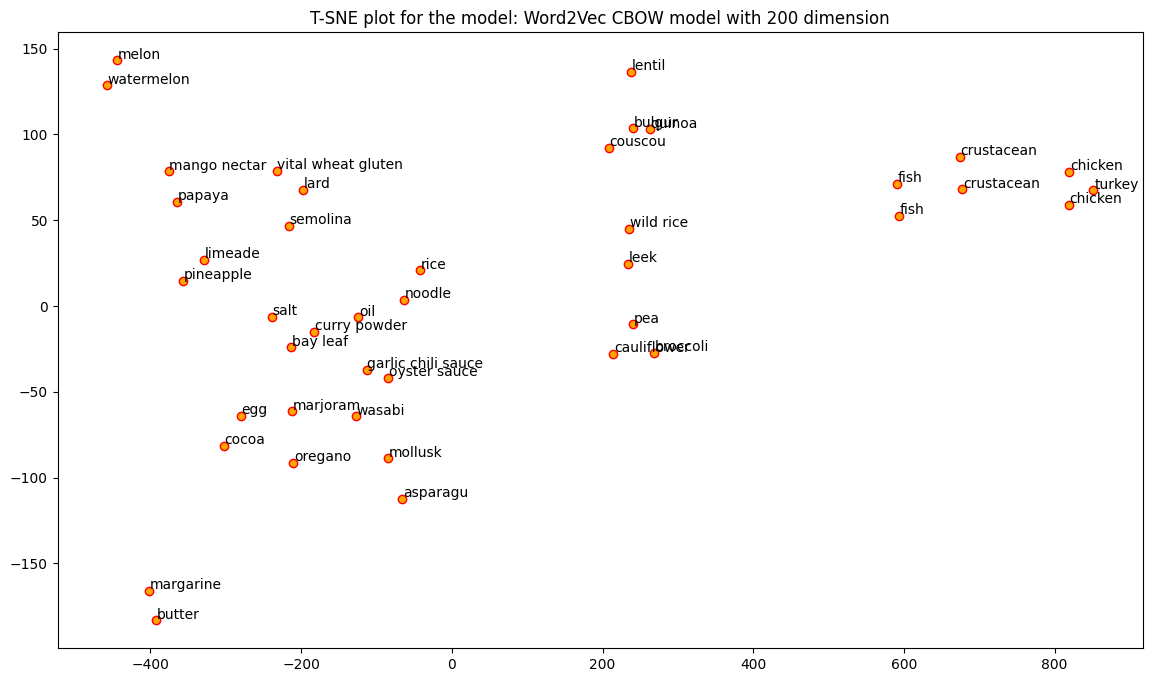

In [9]:
plot_tsne(w2v_model_cbow_200, 'Word2Vec CBOW model with 200 dimension')

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


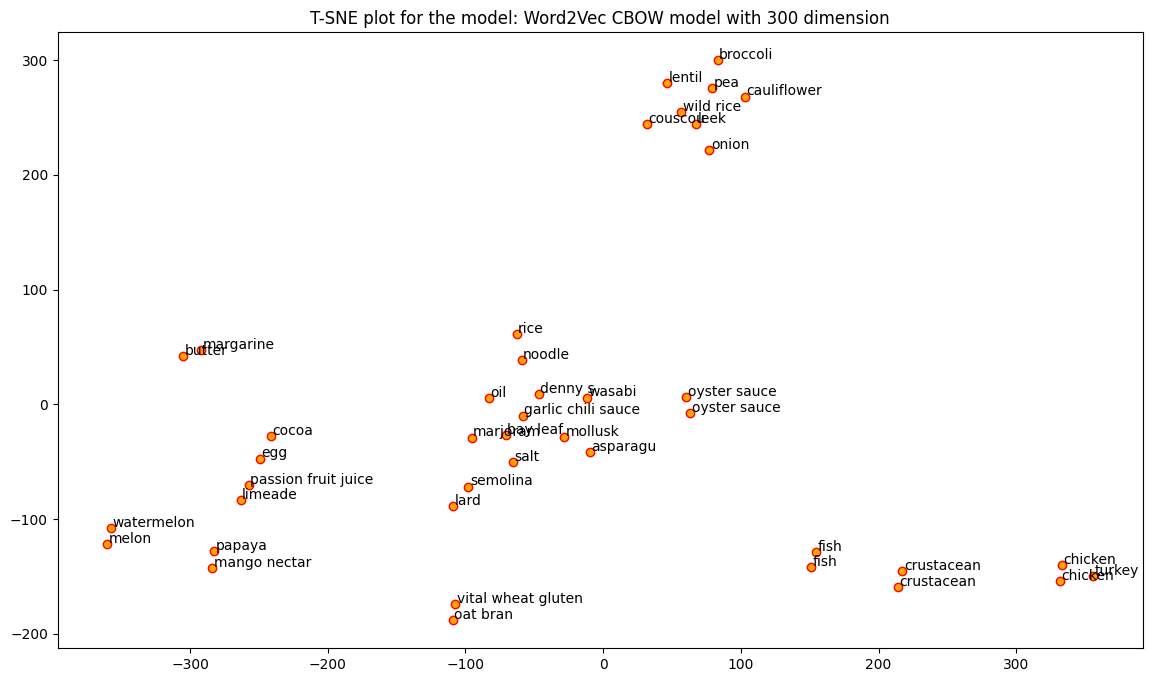

In [10]:
plot_tsne(w2v_model_cbow_300, 'Word2Vec CBOW model with 300 dimension')

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


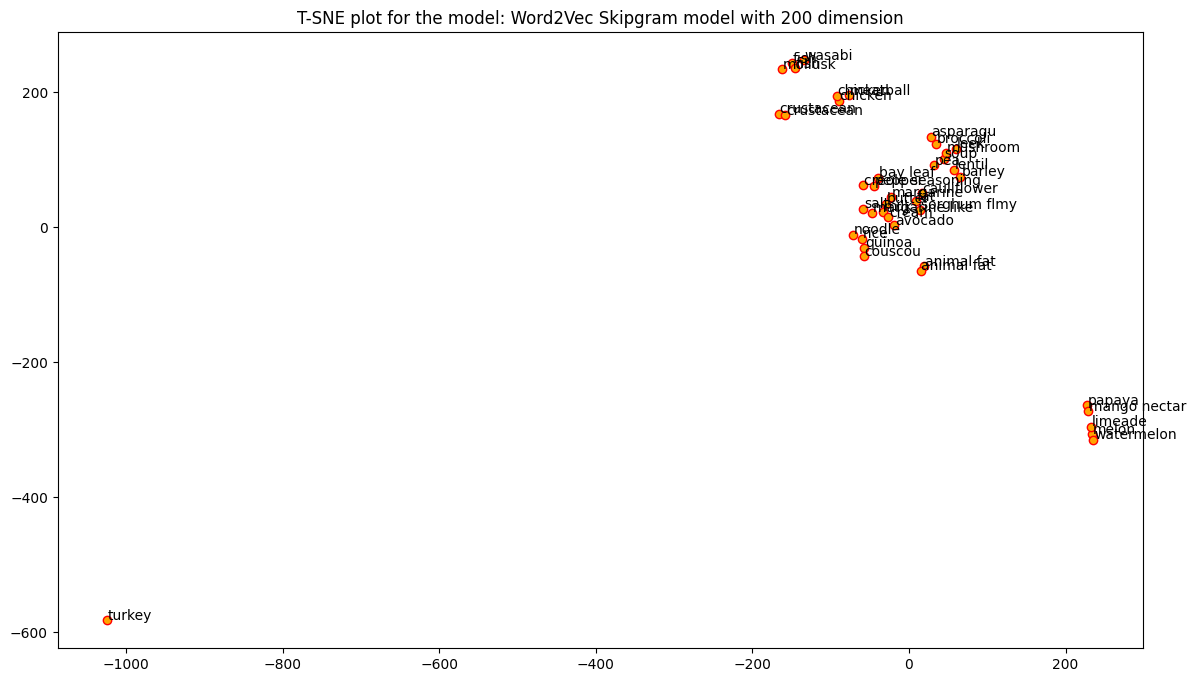

In [11]:
plot_tsne(w2v_model_skipgram_200, 'Word2Vec Skipgram model with 200 dimension')

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


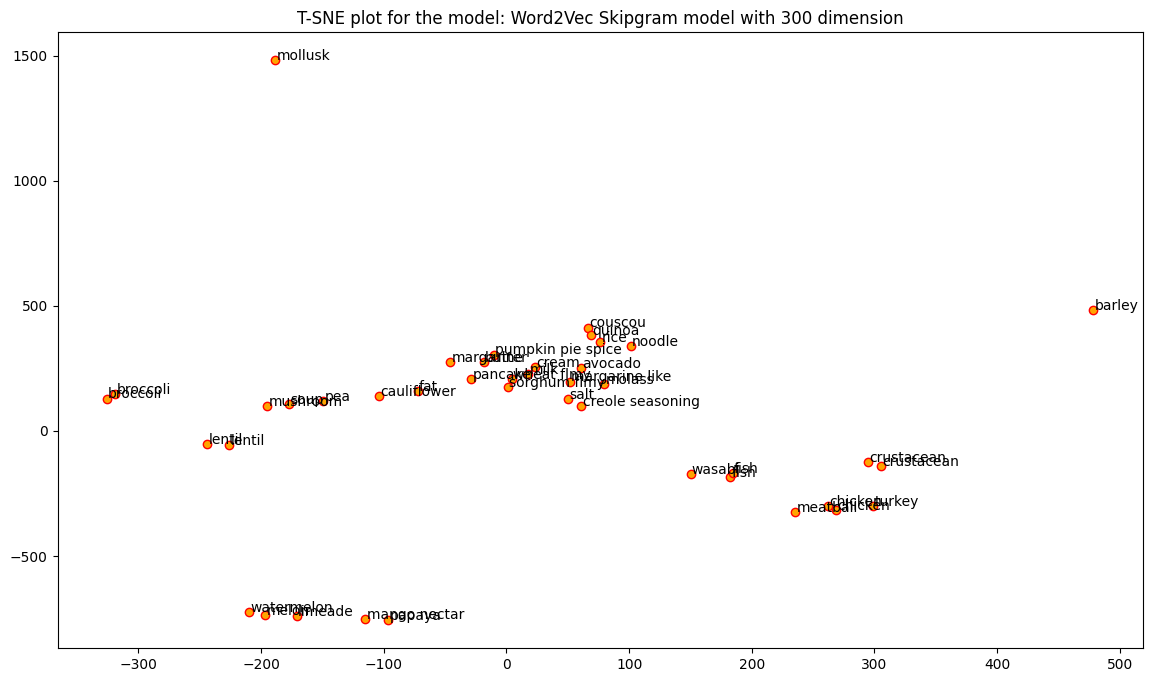

In [12]:
plot_tsne(w2v_model_skipgram_300, 'Word2Vec Skipgram model with 300 dimension')

# FastText Models
### Train 4 variations
- fasttext_model_cbow_200: FastText Model CBOW algorithm with 200 dimensions
- fasttext_model_cbow_300: FastText Model CBOW algorithm with 300 dimensions
- fasttext_model_skipgram_200: FastText Model Skip-gram algorithm with 200 dimensions
- fasttext_model_skipgram_300: FastText Model Skip-gram algorithm with 300 dimensions

In [47]:
from gensim.models import FastText

In [48]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer                  
min_word_count = 5                        
context_window_size = 4    # Context window size; 
downsampling = 1e-2         # threshold for configuring which 
                            # higher-frequency words are randomly downsampled
sg = 0 # CBOW: build a language model that correctly predicts the center word given the context words in which the center word appears

fasttext_model_cbow_200 = FastText(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=200,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg=0)

fasttext_model_cbow_300 = FastText(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=300,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg=0)

fasttext_model_skipgram_200 = FastText(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=200,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg=1)

fasttext_model_skipgram_300 = FastText(min_count=min_word_count,
                     window=context_window_size,
                     vector_size=300,
                     sample=downsampling, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     sg=1)

INFO - 10:31:33: FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=200, alpha=0.03>', 'datetime': '2023-01-18T10:31:33.521434', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 10:31:33: FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2023-01-18T10:31:33.522349', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 10:31:33: FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=200, alpha=0.03>', 'datetime': '2023-01-18T10:31:33.523032', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'created'}
INFO - 10:31:33: FastText lifecycle event {

In [49]:
# fasttext_model_cbow_200
t = time()
fasttext_model_cbow_200.build_vocab(all_receipes_ingredients, progress_per=5000)
print('fasttext_model_cbow_200: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:31:37: collecting all words and their counts
INFO - 10:31:37: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:31:37: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:31:37: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:31:37: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:31:37: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:31:37: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:31:37: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:31:37: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:31:37: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:31:37: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:31:37: C

fasttext_model_cbow_200: Time to build vocab: 0.03 mins


In [50]:
# fasttext_model_cbow_300
t = time()
fasttext_model_cbow_300.build_vocab(all_receipes_ingredients, progress_per=5000)
print('fasttext_model_cbow_300: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:31:43: collecting all words and their counts
INFO - 10:31:43: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:31:43: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:31:43: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:31:43: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:31:43: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:31:43: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:31:43: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:31:43: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:31:43: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:31:43: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:31:43: C

fasttext_model_cbow_300: Time to build vocab: 0.04 mins


In [51]:
# fasttext_model_skipgram_200
t = time()
fasttext_model_skipgram_200.build_vocab(all_receipes_ingredients, progress_per=5000)
print('fasttext_model_skipgram_200: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:31:52: collecting all words and their counts
INFO - 10:31:52: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:31:52: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:31:52: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:31:52: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:31:52: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:31:52: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:31:52: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:31:52: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:31:52: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:31:52: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:31:52: C

fasttext_model_skipgram_200: Time to build vocab: 0.03 mins


In [52]:
# fasttext_model_skipgram_300
t = time()
fasttext_model_skipgram_300.build_vocab(all_receipes_ingredients, progress_per=5000)
print('fasttext_model_skipgram_300: Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:31:57: collecting all words and their counts
INFO - 10:31:57: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:31:57: PROGRESS: at sentence #5000, processed 30020 words, keeping 229 word types
INFO - 10:31:57: PROGRESS: at sentence #10000, processed 59988 words, keeping 238 word types
INFO - 10:31:57: PROGRESS: at sentence #15000, processed 89876 words, keeping 238 word types
INFO - 10:31:57: PROGRESS: at sentence #20000, processed 119939 words, keeping 238 word types
INFO - 10:31:57: PROGRESS: at sentence #25000, processed 150111 words, keeping 240 word types
INFO - 10:31:57: PROGRESS: at sentence #30000, processed 180067 words, keeping 240 word types
INFO - 10:31:57: PROGRESS: at sentence #35000, processed 210129 words, keeping 240 word types
INFO - 10:31:57: PROGRESS: at sentence #40000, processed 239839 words, keeping 240 word types
INFO - 10:31:57: collected 240 word types from a corpus of 261064 raw words and 43554 sentences
INFO - 10:31:57: C

fasttext_model_skipgram_300: Time to build vocab: 0.04 mins


In [53]:
# fasttext_model_cbow_200

t = time()
fasttext_model_cbow_200.train(all_receipes_ingredients, total_examples=fasttext_model_cbow_200.corpus_count, epochs=30, report_delay=1)
print('fasttext_model_cbow_200: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:32:03: FastText lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 200 features, using sg=0 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:32:03.367620', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:32:03: EPOCH 0: training on 261064 raw words (220917 effective words) took 0.6s, 376491 effective words/s
INFO - 10:32:04: EPOCH 1: training on 261064 raw words (220913 effective words) took 0.5s, 458505 effective words/s
INFO - 10:32:04: EPOCH 2: training on 261064 raw words (220883 effective words) took 0.5s, 464681 effective words/s
INFO - 10:32:05: EPOCH 3: training on 261064 raw words (220983 effective words) took 0.5s, 457217 effective words/s
INFO - 10:32:05: EPOCH 4: training on 261064 raw words (220700 effective words) took 0.5s, 466504 effective words/s
INFO - 10:32:06: E

fasttext_model_cbow_200: Time to train the model: 0.25 mins


In [54]:
# fasttext_model_cbow_300

t = time()
fasttext_model_cbow_300.train(all_receipes_ingredients, total_examples=fasttext_model_cbow_300.corpus_count, epochs=30, report_delay=1)
print('fasttext_model_cbow_300: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:32:21: FastText lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 300 features, using sg=0 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:32:21.150194', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:32:21: EPOCH 0: training on 261064 raw words (220773 effective words) took 0.7s, 305381 effective words/s
INFO - 10:32:22: EPOCH 1: training on 261064 raw words (221010 effective words) took 0.6s, 342454 effective words/s
INFO - 10:32:23: EPOCH 2: training on 261064 raw words (220807 effective words) took 0.6s, 353987 effective words/s
INFO - 10:32:23: EPOCH 3: training on 261064 raw words (220724 effective words) took 0.6s, 342957 effective words/s
INFO - 10:32:24: EPOCH 4: training on 261064 raw words (221041 effective words) took 0.6s, 360078 effective words/s
INFO - 10:32:25: E

fasttext_model_cbow_300: Time to train the model: 0.32 mins


In [55]:
# fasttext_model_skipgram_200

t = time()
fasttext_model_skipgram_200.train(all_receipes_ingredients, total_examples=fasttext_model_skipgram_200.corpus_count, epochs=30, report_delay=1)
print('fasttext_model_skipgram_200: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:32:44: FastText lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 200 features, using sg=1 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:32:44.139317', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:32:44: EPOCH 0: training on 261064 raw words (220788 effective words) took 0.8s, 268573 effective words/s
INFO - 10:32:45: EPOCH 1: training on 261064 raw words (220959 effective words) took 0.8s, 281806 effective words/s
INFO - 10:32:46: EPOCH 2: training on 261064 raw words (220771 effective words) took 0.8s, 289925 effective words/s
INFO - 10:32:47: EPOCH 3: training on 261064 raw words (220772 effective words) took 0.8s, 283889 effective words/s
INFO - 10:32:48: EPOCH 4: training on 261064 raw words (221057 effective words) took 0.8s, 286115 effective words/s
INFO - 10:32:48: E

fasttext_model_skipgram_200: Time to train the model: 0.39 mins


In [56]:
# fasttext_model_skipgram_300

t = time()
fasttext_model_skipgram_300.train(all_receipes_ingredients, total_examples=fasttext_model_skipgram_300.corpus_count, epochs=30, report_delay=1)
print('fasttext_model_skipgram_300: Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:33:09: FastText lifecycle event {'msg': 'training model with 7 workers on 237 vocabulary and 300 features, using sg=1 hs=0 sample=0.01 negative=20 window=4 shrink_windows=True', 'datetime': '2023-01-18T10:33:09.868537', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'train'}
INFO - 10:33:10: EPOCH 0 - PROGRESS: at 92.29% examples, 201562 words/s, in_qsize 2, out_qsize 1
INFO - 10:33:10: EPOCH 0: training on 261064 raw words (221009 effective words) took 1.0s, 212347 effective words/s
INFO - 10:33:11: EPOCH 1: training on 261064 raw words (220824 effective words) took 1.0s, 228713 effective words/s
INFO - 10:33:12: EPOCH 2: training on 261064 raw words (221031 effective words) took 1.0s, 228584 effective words/s
INFO - 10:33:13: EPOCH 3: training on 261064 raw words (220924 effective words) took 1.0s, 225396 effective words/s
INFO - 10:33:14: EPOCH 4: training on

fasttext_model_skipgram_300: Time to train the model: 0.51 mins


In [57]:
# Save the 4 variations

fasttext_model_cbow_200.save('models/fasttext_model_cbow_200.bin')
fasttext_model_cbow_300.save('models/fasttext_model_cbow_300.bin')
fasttext_model_skipgram_200.save('models/fasttext_model_skipgram_200.bin')
fasttext_model_skipgram_300.save('models/fasttext_model_skipgram_300.bin')

INFO - 10:33:42: FastText lifecycle event {'fname_or_handle': 'models/fasttext_model_cbow_200.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-01-18T10:33:42.865172', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'saving'}
INFO - 10:33:42: storing np array 'vectors_ngrams' to models/fasttext_model_cbow_200.bin.wv.vectors_ngrams.npy
INFO - 10:33:44: not storing attribute buckets_word
INFO - 10:33:44: not storing attribute vectors
INFO - 10:33:44: not storing attribute cum_table
INFO - 10:33:44: saved models/fasttext_model_cbow_200.bin
INFO - 10:33:44: FastText lifecycle event {'fname_or_handle': 'models/fasttext_model_cbow_300.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-01-18T10:33:44.368869', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clan

In [15]:
# load the saved models
fasttext_model_cbow_200 = Word2Vec.load('models/fasttext_model_cbow_200.bin')
fasttext_model_cbow_300 = Word2Vec.load('models/fasttext_model_cbow_300.bin')
fasttext_model_skipgram_200 = Word2Vec.load('models/fasttext_model_skipgram_200.bin')
fasttext_model_skipgram_300 = Word2Vec.load('models/fasttext_model_skipgram_300.bin')

INFO - 23:29:04: loading Word2Vec object from models/fasttext_model_cbow_200.bin
INFO - 23:29:04: loading wv recursively from models/fasttext_model_cbow_200.bin.wv.* with mmap=None
INFO - 23:29:04: loading vectors_ngrams from models/fasttext_model_cbow_200.bin.wv.vectors_ngrams.npy with mmap=None
INFO - 23:29:05: setting ignored attribute buckets_word to None
INFO - 23:29:05: setting ignored attribute vectors to None
INFO - 23:29:05: setting ignored attribute cum_table to None
INFO - 23:29:05: FastText lifecycle event {'fname': 'models/fasttext_model_cbow_200.bin', 'datetime': '2023-01-24T23:29:05.158899', 'gensim': '4.3.0', 'python': '3.8.9 (default, Apr 13 2022, 08:48:06) \n[Clang 13.1.6 (clang-1316.0.21.2.5)]', 'platform': 'macOS-12.2.1-arm64-arm-64bit', 'event': 'loaded'}
INFO - 23:29:05: loading Word2Vec object from models/fasttext_model_cbow_300.bin
INFO - 23:29:05: loading wv recursively from models/fasttext_model_cbow_300.bin.wv.* with mmap=None
INFO - 23:29:05: loading vectors

In [16]:
# Comparison 1

print('Similarity between chicken and turkey')
print('fasttext_model_cbow_200:', fasttext_model_cbow_200.wv.similarity('chicken','turkey'))
print('fasttext_model_cbow_300:', fasttext_model_cbow_300.wv.similarity('chicken','turkey'))
print('fasttext_model_skipgram_200:', fasttext_model_skipgram_200.wv.similarity('chicken','turkey'))
print('fasttext_model_skipgram_300:', fasttext_model_skipgram_300.wv.similarity('chicken','turkey'))

Similarity between chicken and turkey
fasttext_model_cbow_200: 0.5976287
fasttext_model_cbow_300: 0.6064038
fasttext_model_skipgram_200: 0.45418727
fasttext_model_skipgram_300: 0.46397465


In [17]:
# Comparison 2
print('Similarity between broccoli and pea')
print('fasttext_model_cbow_200:', fasttext_model_cbow_200.wv.similarity('broccoli','pea'))
print('fasttext_model_cbow_300:', fasttext_model_cbow_300.wv.similarity('broccoli','pea'))
print('fasttext_model_skipgram_200:', fasttext_model_skipgram_200.wv.similarity('broccoli','pea'))
print('fasttext_model_skipgram_300:', fasttext_model_skipgram_300.wv.similarity('broccoli','pea'))

Similarity between broccoli and pea
fasttext_model_cbow_200: 0.6530513
fasttext_model_cbow_300: 0.61580646
fasttext_model_skipgram_200: 0.47816965
fasttext_model_skipgram_300: 0.48179936


/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


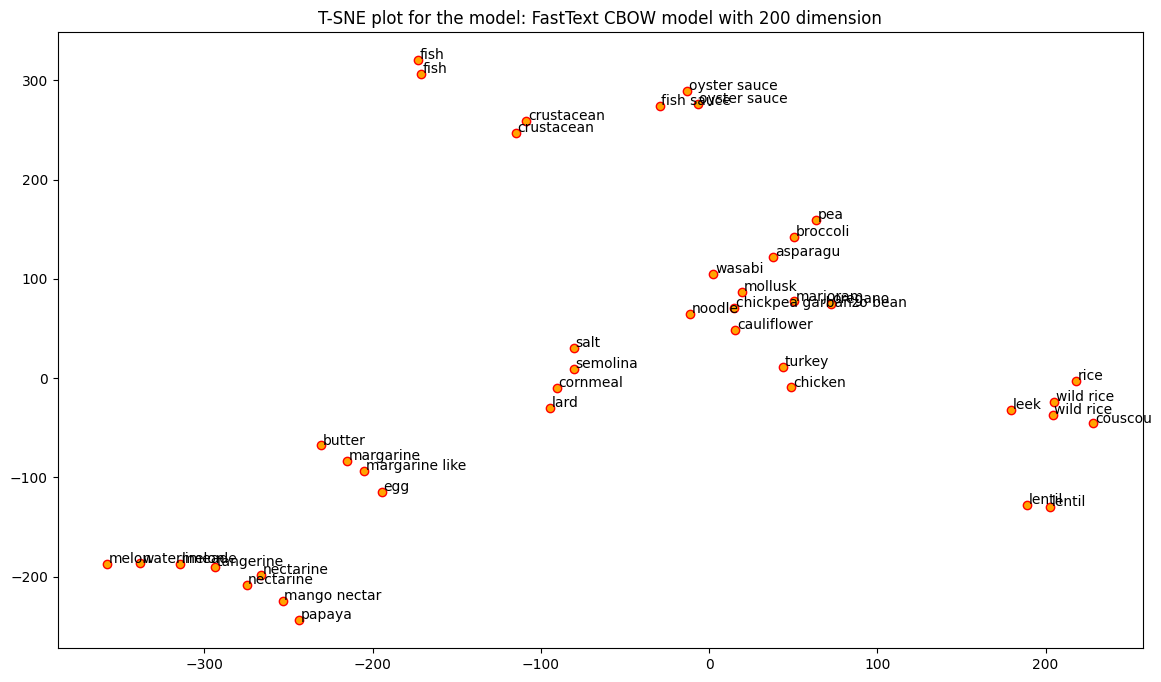

In [18]:
plot_tsne(fasttext_model_cbow_200, 'FastText CBOW model with 200 dimension')

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


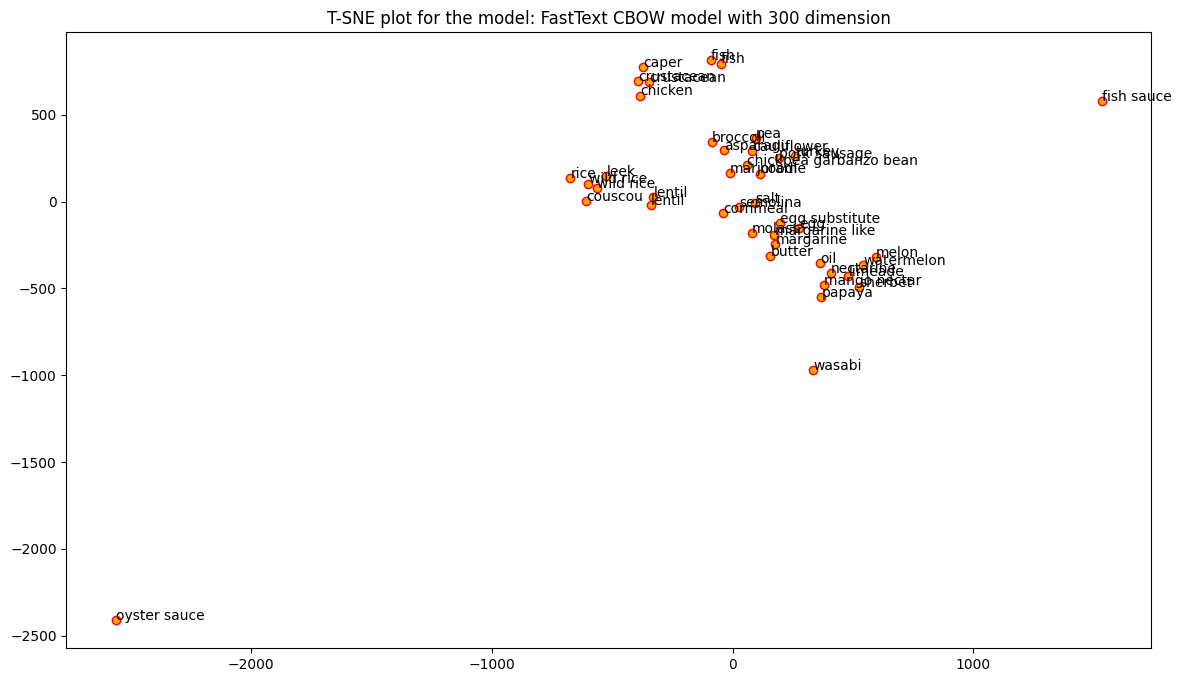

In [23]:
plot_tsne(fasttext_model_cbow_300, 'FastText CBOW model with 300 dimension')

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


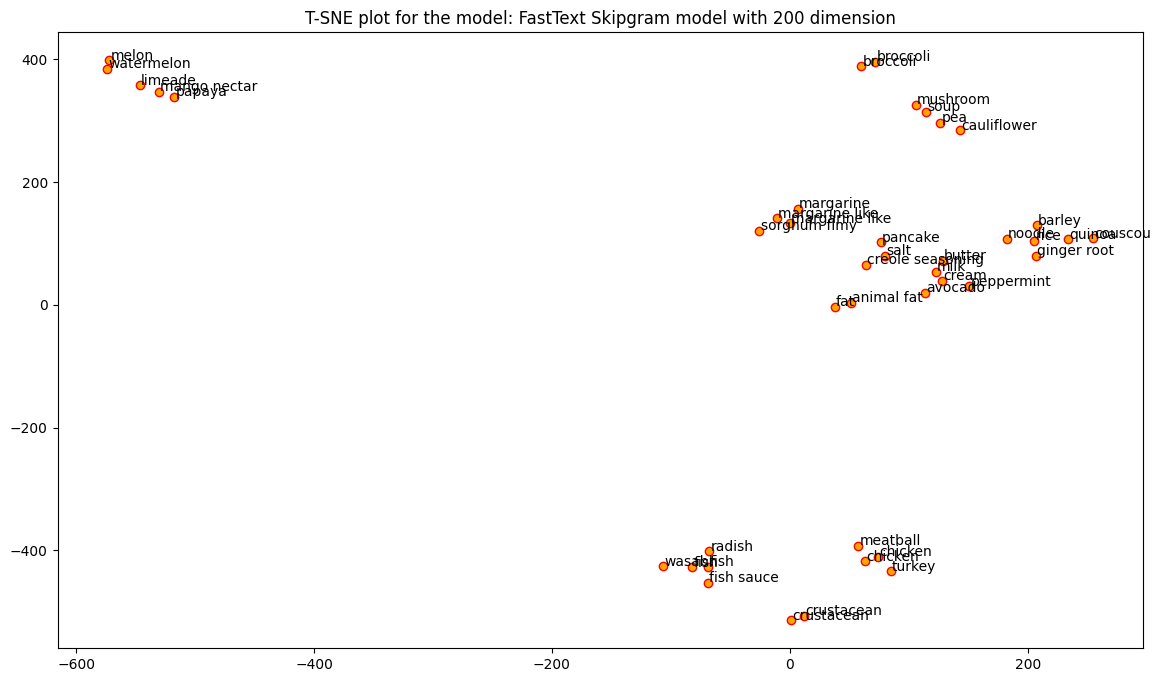

In [21]:
plot_tsne(fasttext_model_skipgram_200, 'FastText Skipgram model with 200 dimension')

/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/thinzar/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


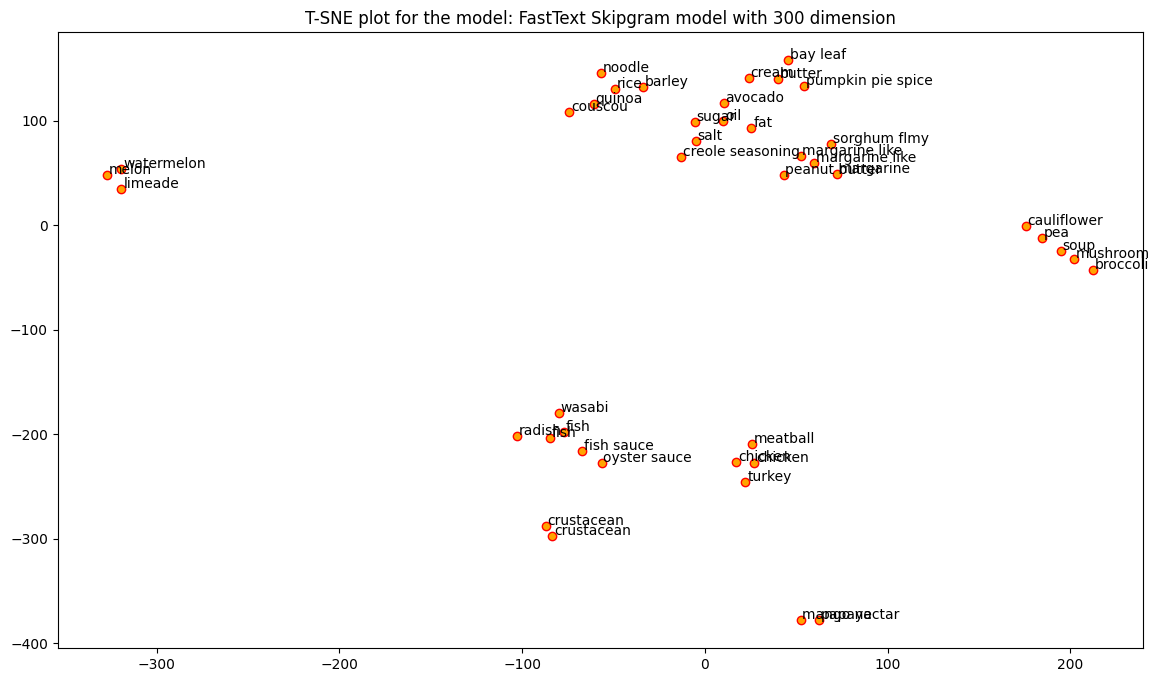

In [22]:
plot_tsne(fasttext_model_skipgram_300, 'FastText Skipgram model with 300 dimension')